In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import PercentFormatter

# Task
Analyze the provided credit card transaction dataset to build a fraud detection model. The analysis should include data loading, exploration, preprocessing, handling class imbalance, model training, evaluation, and prediction.

## Load data


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Copy of fraud.csv')
display(df.head())
print(df.shape)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


(594643, 10)


## Data Exploration and Cleaning

### Explore data


In [ ]:
print(df.columns)
print(df.info())
print(df.isnull().sum())

Index(['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant',
       'zipMerchant', 'category', 'amount', 'fraud'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB
None
step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud 

In [ ]:
fraud = df['fraud'].value_counts()
print(fraud)

fraud
0    587443
1      7200
Name: count, dtype: int64


### Clean Data

In [ ]:
df = df.copy()

#Rename to clearer names
df = df.rename(columns={'zipcodeOri': 'zip_origin', 'zipMerchant': 'zip_merchant'})

#Ensure numeric columns are truly numeric
df['step']  = pd.to_numeric(df['step'],  errors='coerce').astype('Int64')
df['amount']= pd.to_numeric(df['amount'], errors='coerce')
df['fraud'] = pd.to_numeric(df['fraud'],  errors='coerce').fillna(0).astype('int8')

In [ ]:
#Quote-safe cleaners
def strip_quotes(s: pd.Series, upper=True):
    out = (s.astype(str).str.strip().str.strip('"').str.strip("'"))
    return out.str.upper() if upper else out

# Age: coerce to ordered groups ['0'..'6','U'] even if values look like "'4'"
age_order = ['0','1','2','3','4','5','6','U']
age_raw = strip_quotes(df['age'], upper=True)
age_clean = age_raw.where(age_raw.isin(age_order), 'U')
df['age_group'] = pd.Categorical(age_clean, categories=age_order, ordered=True)

# Gender: E/F/M/U, normalize anything else 'U'
gender_valid = {'E','F','M','U'}
g = strip_quotes(df['gender'], upper=True)
g = g.where(g.isin(gender_valid), 'U')
df['gender_clean'] = pd.Categorical(g, categories=['F','M','E','U'])

# Category: strip quotes/casing, keep as category
df['category_clean'] = strip_quotes(df['category'], upper=False).astype('category')

In [ ]:
#same_zip flag (1 if origin == merchant zip)
df['zip_origin']  = strip_quotes(df['zip_origin'], upper=False)
df['zip_merchant']= strip_quotes(df['zip_merchant'], upper=False)
df['same_zip'] = (df['zip_origin'] == df['zip_merchant']).astype('int8')

In [ ]:
# Amount bins
# fine bins in dense region, wider in tail; open-ended top bin
amount_bins   = [0, 10, 25, 50, 75, 150, 250, 500, 1000, 2500, np.inf]
amount_labels = []
for i in range(len(amount_bins)-1):
    left, right = amount_bins[i], amount_bins[i+1]
    if np.isinf(right):
        amount_labels.append(f"{int(left)}+")
    else:
        amount_labels.append(f"{int(left)}–{int(right)}")
df['amount_bin'] = pd.cut(df['amount'], bins=amount_bins, include_lowest=True, labels=amount_labels, ordered=True)

In [ ]:
# Memory-friendly dtypes for high-cardinality IDs (keep for later grouping/feats)
for col in ['customer','merchant','zip_origin','zip_merchant','category_clean']:
    if col in df:
        df[col] = df[col].astype('category')

# Build the final cleaned frame (drop raw/redundant columns)
keep_cols = [
    # IDs (useful for grouping / later feature engineering)
    'customer','merchant','zip_origin','zip_merchant',
    # core features
    'step','amount','amount_bin','same_zip','age_group','gender_clean','category_clean',
    # target
    'fraud'
]
cleaned_df = df[keep_cols].copy()

# Cast numerics to compact types
cleaned_df['step']   = cleaned_df['step'].astype('Int32')
cleaned_df['amount'] = cleaned_df['amount'].astype('float32')

In [ ]:
# Save to CSV for EDA/correlations/modeling
out_path = '/content/drive/MyDrive/cleaned_fraud_df.csv'
cleaned_df.to_csv(out_path, index=False)

print("✅ Cleaning complete.")
print(f"Saved: {out_path}")
print("\nSchema:")
print(cleaned_df.dtypes)
print(f"\nShape: {cleaned_df.shape}")
print("\nHead:")
cleaned_df.head(3)

✅ Cleaning complete.
Saved: /content/drive/MyDrive/cleaned_fraud_df.csv

Schema:
customer          category
merchant          category
zip_origin        category
zip_merchant      category
step                 Int32
amount             float32
amount_bin        category
same_zip              int8
age_group         category
gender_clean      category
category_clean    category
fraud                 int8
dtype: object

Shape: (594643, 12)

Head:


,customer,merchant,zip_origin,zip_merchant,step,amount,amount_bin,same_zip,age_group,gender_clean,category_clean,fraud
0,'C1093826151','M348934600',28007,28007,0,4.550000,0–10,1,4,M,es_transportation,0
1,'C352968107','M348934600',28007,28007,0,39.680000,25–50,1,2,M,es_transportation,0
2,'C2054744914','M1823072687',28007,28007,0,26.889999,25–50,1,4,F,es_transportation,0


### Generating Plots

In [7]:
cleaned_df = pd.read_csv('/content/drive/MyDrive/cleaned_fraud_df.csv')
cleaned_df.dtypes

,0
customer,object
merchant,object
zip_origin,int64
zip_merchant,int64
step,int64
amount,float64
amount_bin,object
same_zip,int64
age_group,object
gender_clean,object


In [15]:
print(cleaned_df.same_zip.value_counts())
print(cleaned_df.zip_merchant.value_counts())
print(cleaned_df.zip_origin.value_counts())
print(cleaned_df.amount_bin.value_counts())
print(cleaned_df.step.unique())

same_zip
1    594643
Name: count, dtype: int64
zip_merchant
28007    594643
Name: count, dtype: int64
zip_origin
28007    594643
Name: count, dtype: int64
amount_bin
25–50        217600
10–25        168847
0–10         107469
50–75         67377
75–150        21581
150–250        6259
250–500        3346
500–1000       1526
1000–2500       358
2500+           280
Name: count, dtype: int64
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149

In [ ]:
cleaned_df.groupby(["category_clean"]).merchant.value_counts()

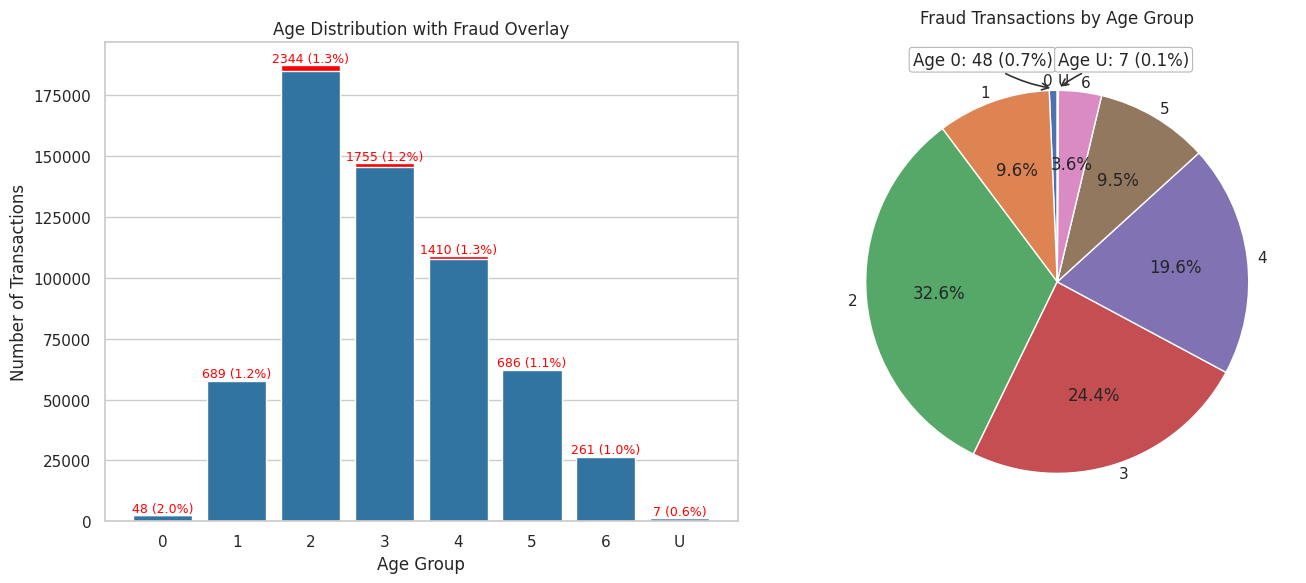

In [4]:
sns.set(style="whitegrid")
dfc = cleaned_df.copy()

# Use strings + explicit order (no .cat needed)
age_order = ['0','1','2','3','4','5','6','U']
s = (dfc['age_group'].astype(str)
                  .str.strip().str.strip('"').str.strip("'").str.upper())
dfc['age_group'] = np.where(s.isin(age_order), s, 'U')

# Counts (ordered)
total_age = dfc['age_group'].value_counts().reindex(age_order, fill_value=0)
fraud_age = dfc.loc[dfc['fraud']==1, 'age_group'].value_counts().reindex(age_order, fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar with fraud overlay
ax1 = sns.countplot(x='age_group', data=dfc, color='#1f77b4', order=age_order, ax=axes[0])
for i, grp in enumerate(age_order):
    f = int(fraud_age[grp]); t = int(total_age[grp])
    if t>0 and f>0:
        p = 100*f/t
        ax1.bar(i, f, color='red', bottom=t-f, width=0.8)
        ax1.text(i, t, f'{f} ({p:.1f}%)', ha='center', va='bottom', color='red', fontsize=9)
ax1.set_title('Age Distribution with Fraud Overlay')
ax1.set_xlabel('Age Group'); ax1.set_ylabel('Number of Transactions')

# Pie (same as before) + arrow callouts for '0' and 'U'
ax2 = axes[1]
fa = fraud_age[fraud_age>0]
if fa.sum()==0:
    ax2.text(0.5,0.5,'No fraud instances', ha='center', va='center')
else:
    labels = fa.index.tolist(); sizes = fa.values
    wedges, texts, autotexts = ax2.pie(
        sizes, labels=labels, autopct='%1.1f%%', startangle=90,
        counterclock=True, labeldistance=1.05, pctdistance=0.62
    )
    ax2.set_title('Fraud Transactions by Age Group', pad=14)
    for i,lbl in enumerate(labels):
        if lbl in ('0','U'):
            autotexts[i].set_visible(False)

    def annotate_slice(lbl, r_text=1.20, r_arrow=1.02, dy_text=-0.04, dy_arrow=-0.01):
        if lbl not in labels: return
        i = labels.index(lbl); w = wedges[i]
        ang = np.deg2rad((w.theta1 + w.theta2)/2.0)
        xa, ya = r_arrow*np.cos(ang), r_arrow*np.sin(ang)
        xt, yt = r_text*np.cos(ang), r_text*np.sin(ang)
        ya += dy_arrow; yt += dy_text
        ha = 'left' if xt>=0 else 'right'
        pct = 100*sizes[i]/np.sum(sizes)
        ax2.annotate(f'Age {lbl}: {int(sizes[i]):,} ({pct:.1f}%)',
                     xy=(xa,ya), xytext=(xt,yt), ha=ha, va='center',
                     bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='0.7', lw=0.8, alpha=0.95),
                     arrowprops=dict(arrowstyle='->', lw=1.2, color='0.2',
                                     connectionstyle='arc3,rad=0.12'))
    annotate_slice('0'); annotate_slice('U')

plt.tight_layout(); plt.show()

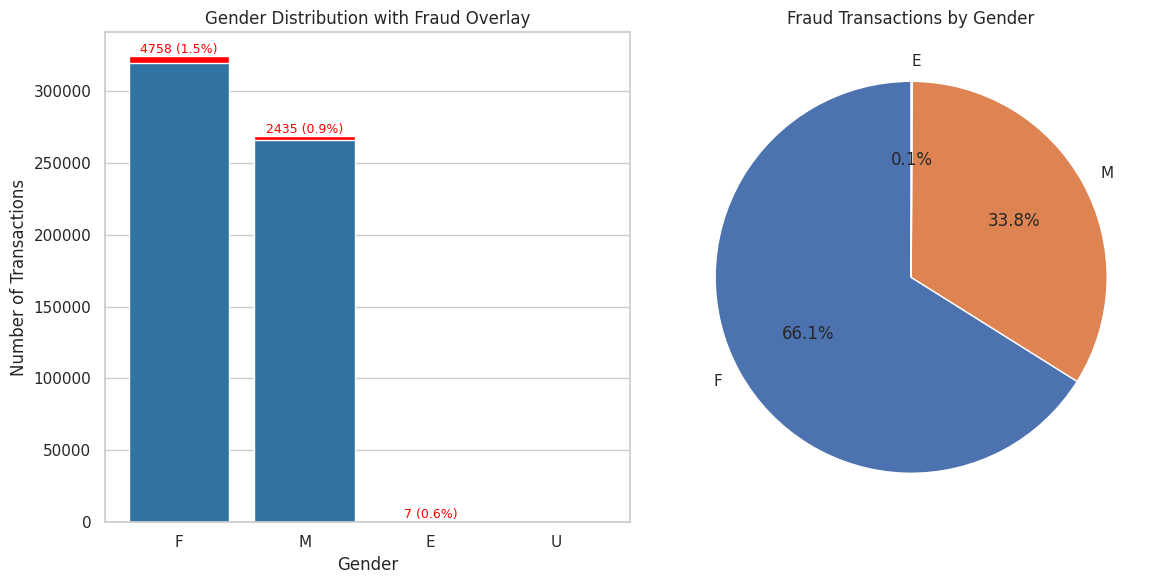

In [5]:
# GENDER: bar (with fraud overlay) + pie

# Use categorical order if present; else fall back to observed order
if pd.api.types.is_categorical_dtype(dfc['gender_clean']):
    g_order = list(dfc['gender_clean'].cat.categories)
else:
    g_order = list(dfc['gender_clean'].value_counts().index)

total_g = dfc['gender_clean'].value_counts().reindex(g_order, fill_value=0)
fraud_g = dfc.loc[dfc['fraud'] == 1, 'gender_clean'].value_counts().reindex(g_order, fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax1 = sns.countplot(x='gender_clean', data=dfc, color='#1f77b4', order=g_order, ax=axes[0])

for i, grp in enumerate(g_order):
    fcnt = int(fraud_g[grp]); tcnt = int(total_g[grp])
    if tcnt > 0 and fcnt > 0:
        perc = 100.0 * fcnt / tcnt
        ax1.bar(i, fcnt, color='red', bottom=tcnt - fcnt, width=0.8)
        ax1.text(i, tcnt, f'{fcnt} ({perc:.1f}%)', ha='center', va='bottom', color='red', fontsize=9)

ax1.set_title('Gender Distribution with Fraud Overlay')
ax1.set_xlabel('Gender'); ax1.set_ylabel('Number of Transactions')

fraud_g_nonzero = fraud_g[fraud_g > 0]
if fraud_g_nonzero.sum() == 0:
    axes[1].text(0.5, 0.5, 'No fraud instances', ha='center', va='center')
else:
    axes[1].pie(fraud_g_nonzero, labels=fraud_g_nonzero.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Fraud Transactions by Gender')

plt.tight_layout()
plt.show()


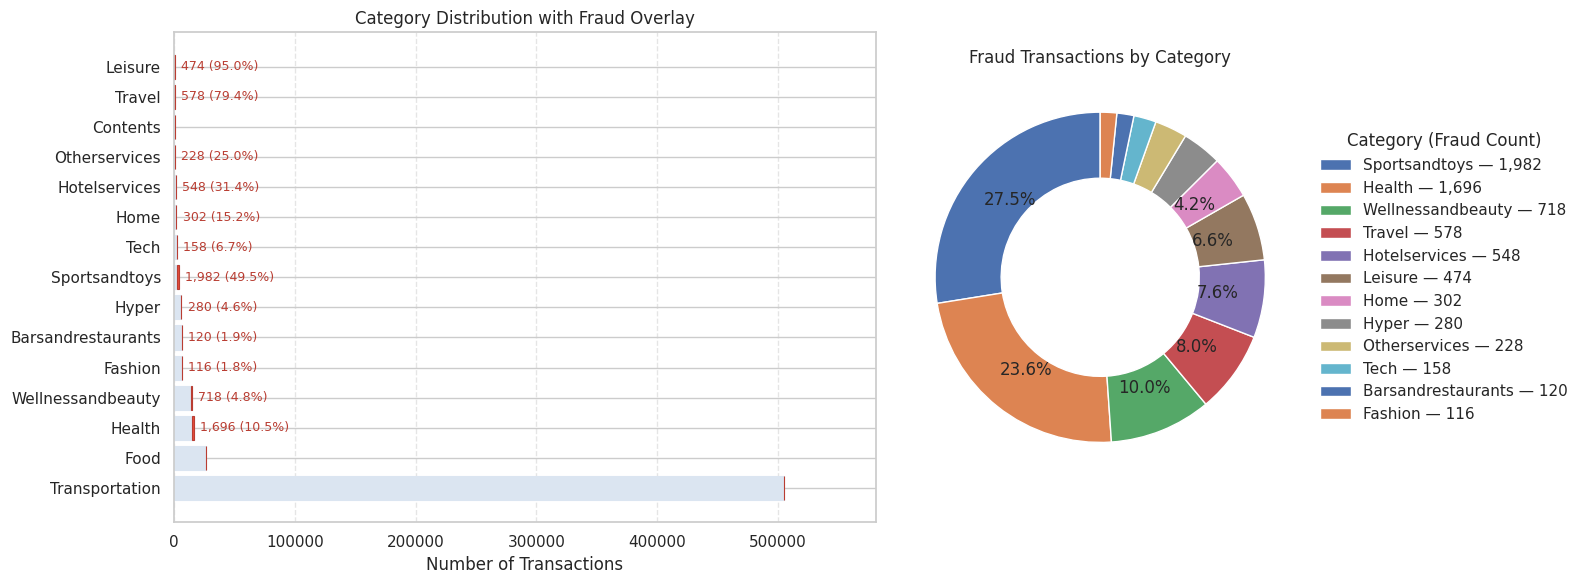

In [6]:
#CATEGORY: bar (with fraud overlay) + pie
def pretty_cat(s: pd.Series) -> pd.Series:
    return (s.astype(str)
              .str.replace(r'^es_', '', regex=True)
              .str.replace('_', ' ')
              .str.title())

dfc['category_pretty'] = pretty_cat(dfc['category_clean'])

# --- Summaries ---
totals = dfc['category_pretty'].value_counts()
frauds = dfc.loc[dfc['fraud'] == 1, 'category_pretty'].value_counts()
summary = (pd.DataFrame({'total': totals, 'fraud': frauds})
             .fillna(0).astype(int))
summary['fraud_rate'] = summary['fraud'] / summary['total']

# Show top-N by total volume to avoid clutter (set None to show all)
top_n = None
summary = summary.sort_values('total', ascending=True)
if top_n is not None and len(summary) > top_n:
    summary = summary.tail(top_n)

# Figure layout (wider bar panel)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1.7, 1]})


# Left: Horizontal stacked bars (total with red fraud cap)
ax = axes[0]
y = np.arange(len(summary))
tot = summary['total'].to_numpy()
frd = summary['fraud'].to_numpy()

# Base (total) and red cap (fraud)
ax.barh(y, tot, color='#DBE5F1', edgecolor='#DBE5F1', linewidth=0.8)
ax.barh(y, frd, left=tot - frd, color='#E74C3C', edgecolor='#B93D32', linewidth=0.8)

# Annotate fraud counts
xmax = tot.max()
xoff = max(6, int(xmax * 0.01))  # small offset to the right
for i, (t, f) in enumerate(zip(tot, frd)):
    if f > 0 and t > 0:
        perc = 100 * f / t
        ax.text(t + xoff, i, f'{f:,} ({perc:.1f}%)',
                va='center', ha='left', fontsize=9, color='#B93D32')

ax.set_yticks(y)
ax.set_yticklabels(summary.index)
ax.set_xlabel('Number of Transactions')
ax.set_title('Category Distribution with Fraud Overlay')
ax.grid(axis='x', ls='--', alpha=0.5)
ax.set_xlim(0, xmax * 1.15)
ax.invert_yaxis()

# Right: Donut of fraud counts
ax2 = axes[1]
pie_df = summary[summary['fraud'] > 0].sort_values('fraud', ascending=False)

if pie_df.empty:
    ax2.text(0.5, 0.5, 'No fraud instances', ha='center', va='center')
    ax2.set_axis_off()
else:
    # Group tiny slices into "Other" for readability
    max_slices = 13
    sizes = pie_df['fraud'].to_numpy()
    labels = pie_df.index.to_list()
    if len(sizes) > max_slices:
        keep = max_slices - 1
        sizes = np.r_[sizes[:keep], sizes[keep:].sum()]
        labels = labels[:keep] + ['Other']

    wedges, texts, autotexts = ax2.pie(
        sizes,
        labels=None,  # using legend
        autopct=lambda p: f'{p:.1f}%' if p >= 4 else '', #hiding small percentages
        startangle=90,
        counterclock=True,
        pctdistance=0.72,
        wedgeprops=dict(width=0.4, edgecolor='white')
    )
    ax2.set_aspect('equal')
    ax2.set_title('Fraud Transactions by Category')

    # Legend (outside) with counts
    legend_labels = [f'{lbl} — {val:,}' for lbl, val in zip(labels, sizes)]
    ax2.legend(wedges, legend_labels, title='Category (Fraud Count)',
               loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)

plt.tight_layout()
plt.show()

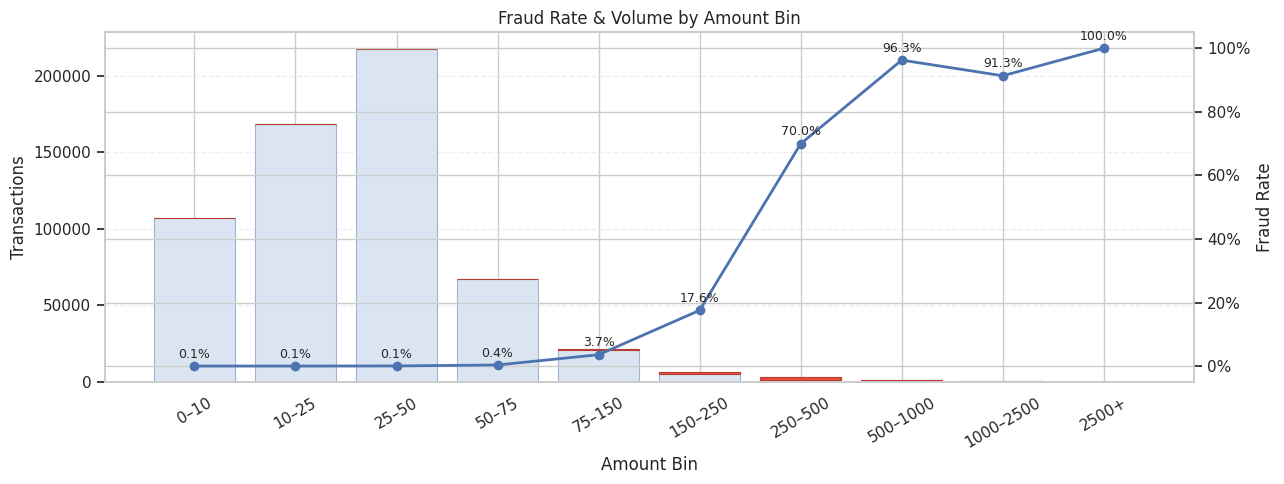

In [9]:
#Build a reliable order from string labels (object dtype)
def _normalize_label(s: str) -> str:
    # unify dashes, strip spaces/commas
    return (s.replace('\u2013','-').replace('\u2014','-')
             .replace(' ', '').replace(',', ''))

def _left_edge(s: str) -> float:
    t = _normalize_label(s)
    # "2500+" -> 2500 ; "0-10" -> 0
    t = t.replace('+','')
    try:
        return float(t.split('-', 1)[0])
    except Exception:
        return np.inf  # push unknowns to the end

# Unique labels in the data, keep original text for display
u = pd.Series(dfc['amount_bin'].dropna().astype(str).unique())
order_df = pd.DataFrame({'label_orig': u})
order_df['left'] = order_df['label_orig'].map(_left_edge)
order_df = order_df.sort_values('left', kind='mergesort')
bin_order = order_df['label_orig'].tolist()

#Summary using that explicit order
summary = (dfc.groupby('amount_bin')['fraud']
             .agg(txn_count='size', fraud_count='sum')
             .reindex(bin_order))
summary['fraud_rate'] = summary['fraud_count'] / summary['txn_count']

#Plot: total with red fraud cap + fraud-rate line
fig, ax1 = plt.subplots(figsize=(13,5))
x = np.arange(len(summary))

ax1.bar(x, summary['txn_count'], color='#DBE5F1', edgecolor='#9FB3D6', linewidth=0.8)
ax1.bar(x, summary['fraud_count'],
        bottom=summary['txn_count']-summary['fraud_count'],
        color='#E74C3C', edgecolor='#B93D32', linewidth=0.8)

ax1.set_ylabel('Transactions')
ax1.set_xlabel('Amount Bin')
ax1.set_xticks(x)
ax1.set_xticklabels(summary.index.astype(str), rotation=30)
ax1.set_title('Fraud Rate & Volume by Amount Bin')
ax1.grid(axis='y', ls='--', alpha=0.35)

ax2 = ax1.twinx()
ax2.plot(x, summary['fraud_rate'], marker='o', linewidth=2)
ax2.set_ylabel('Fraud Rate')
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))

for xi, r in zip(x, summary['fraud_rate']):
    if pd.notna(r):
        ax2.annotate(f'{r:.1%}', (xi, r), textcoords='offset points', xytext=(0,6),
                     ha='center', fontsize=9)

plt.tight_layout()
plt.show()

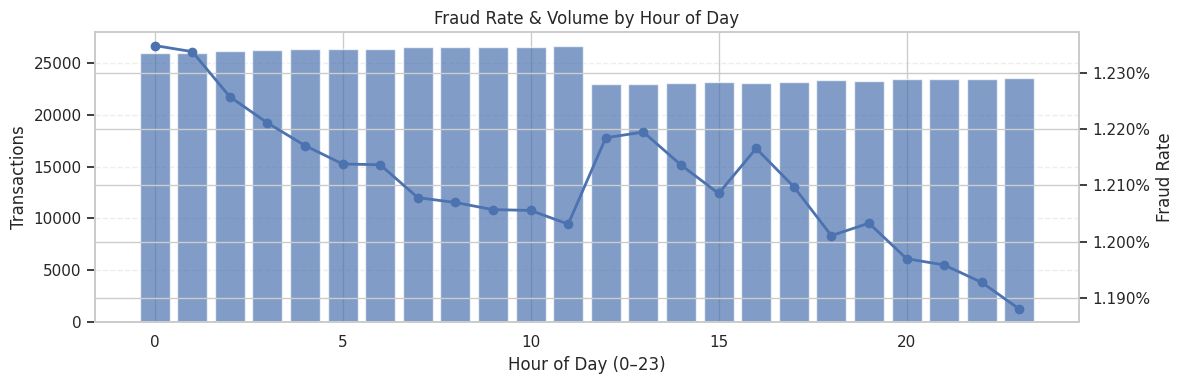

In [8]:
# Hour-of-day pattern (no new columns saved)
hour = (dfc['step'].astype(int) % 24)
hour_summary = (dfc.assign(hour=hour)
                  .groupby('hour')['fraud']
                  .agg(txn_count='size', fraud_count='sum'))
hour_summary['fraud_rate'] = hour_summary['fraud_count'] / hour_summary['txn_count']
hour_summary = hour_summary.reindex(range(24)).fillna(0)

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.bar(hour_summary.index, hour_summary['txn_count'], alpha=0.7)
ax1.set_xlabel('Hour of Day (0–23)')
ax1.set_ylabel('Transactions')
ax1.set_title('Fraud Rate & Volume by Hour of Day')
ax1.grid(axis='y', ls='--', alpha=0.35)

ax2 = ax1.twinx()
ax2.plot(hour_summary.index, hour_summary['fraud_rate'], marker='o', linewidth=2)
ax2.set_ylabel('Fraud Rate')
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout()
plt.show()

In [11]:
def binom_wilson(k, n, z=1.96):
    if n==0: return (0.0, 0.0)
    p = k/n
    denom = 1 + z**2/n
    centre = p + z*z/(2*n)
    half = z*np.sqrt((p*(1-p) + z*z/(4*n))/n)
    lo = (centre - half)/denom
    hi = (centre + half)/denom
    return lo, hi

def summarize_rate(df, col):
    g = (df.groupby(col)['fraud']
           .agg(txn_count='size', fraud_count='sum')
           .reset_index())
    g['fraud_rate'] = g['fraud_count']/g['txn_count']
    g[['ci_lo','ci_hi']] = g.apply(lambda r: pd.Series(binom_wilson(r['fraud_count'], r['txn_count'])), axis=1)
    return g.sort_values('fraud_rate', ascending=False)

print(summarize_rate(cleaned_df, 'category_clean').head(15))
print(summarize_rate(cleaned_df, 'amount_bin'))
print(summarize_rate(cleaned_df, 'gender_clean'))
print(summarize_rate(cleaned_df, 'age_group'))


           category_clean  txn_count  fraud_count  fraud_rate         ci_lo  \
8              es_leisure        499          474    0.949900  9.270876e-01   
13              es_travel        728          578    0.793956  7.630685e-01   
10       es_sportsandtoys       4002         1982    0.495252  4.797738e-01   
6        es_hotelservices       1744          548    0.314220  2.928619e-01   
9        es_otherservices        912          228    0.250000  2.229846e-01   
5                 es_home       1986          302    0.152064  1.369442e-01   
4               es_health      16133         1696    0.105126  1.004868e-01   
11                es_tech       2370          158    0.066667  5.730879e-02   
14   es_wellnessandbeauty      15086          718    0.047594  4.430998e-02   
7                es_hyper       6098          280    0.045917  4.094305e-02   
0   es_barsandrestaurants       6373          120    0.018829  1.577060e-02   
2              es_fashion       6454          116   

In [12]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = cleaned_df[['amount_bin','age_group','gender_clean','category_clean']]
y = cleaned_df['fraud'].astype(int)

pre = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), X.columns)])
# Fit once to get encoded matrix
Xt = pre.fit_transform(X)
mi = mutual_info_classif(Xt, y, discrete_features=True, random_state=42)
print("Total MI across all one-hot features:", mi.sum())


Total MI across all one-hot features: 0.09450148336981343


In [13]:
def top_entities(df, key, min_txn=200):
    g = (df.groupby(key)['fraud']
           .agg(txn_count='size', fraud_count='sum')
           .reset_index())
    g = g[g['txn_count'] >= min_txn].copy()
    g['fraud_rate'] = g['fraud_count']/g['txn_count']
    return g.sort_values('fraud_rate', ascending=False)

print(top_entities(cleaned_df, 'merchant', min_txn=200).head(10))
print(top_entities(cleaned_df, 'customer', min_txn=50).head(10))


         merchant  txn_count  fraud_count  fraud_rate
32     'M3697346'        308          290    0.941558
21  'M1873032707'        250          216    0.864000
40   'M732195782'        608          518    0.851974
49   'M980657600'       1769         1472    0.832109
25  'M2011752106'        244          166    0.680328
14    'M17379832'        282          178    0.631206
28  'M2122776122'        341          200    0.586510
34   'M480139044'       3508         1634    0.465792
15  'M1741626453'        528          196    0.371212
46   'M923029380'        323          102    0.315789
           customer  txn_count  fraud_count  fraud_rate
3926   'C910454738'         92           87    0.945652
2187  'C2004941826'        126          119    0.944444
2816   'C381007057'        100           89    0.890000
1249  'C1572610482'        101           89    0.881188
2402  'C2113737065'         91           79    0.868132
3035   'C483912131'         98           80    0.816327
1782  'C181731

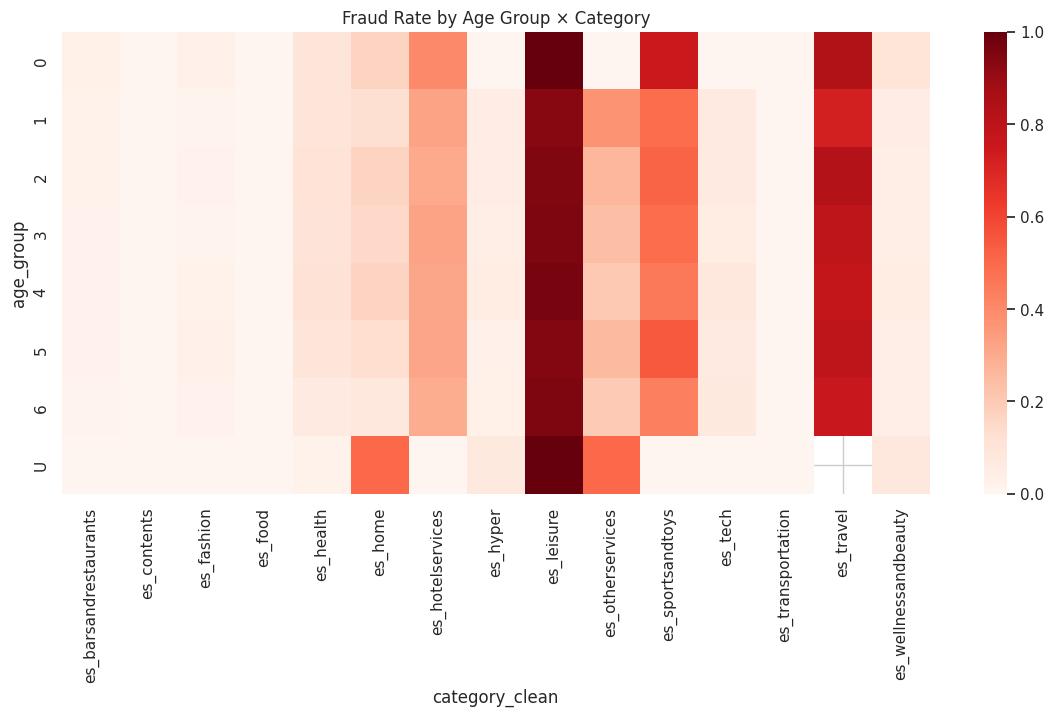

In [14]:
import seaborn as sns, matplotlib.pyplot as plt

pivot = pd.crosstab(cleaned_df['age_group'], cleaned_df['category_clean'],
                    values=cleaned_df['fraud'], aggfunc='mean')
plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap='Reds')
plt.title('Fraud Rate by Age Group × Category')
plt.show()


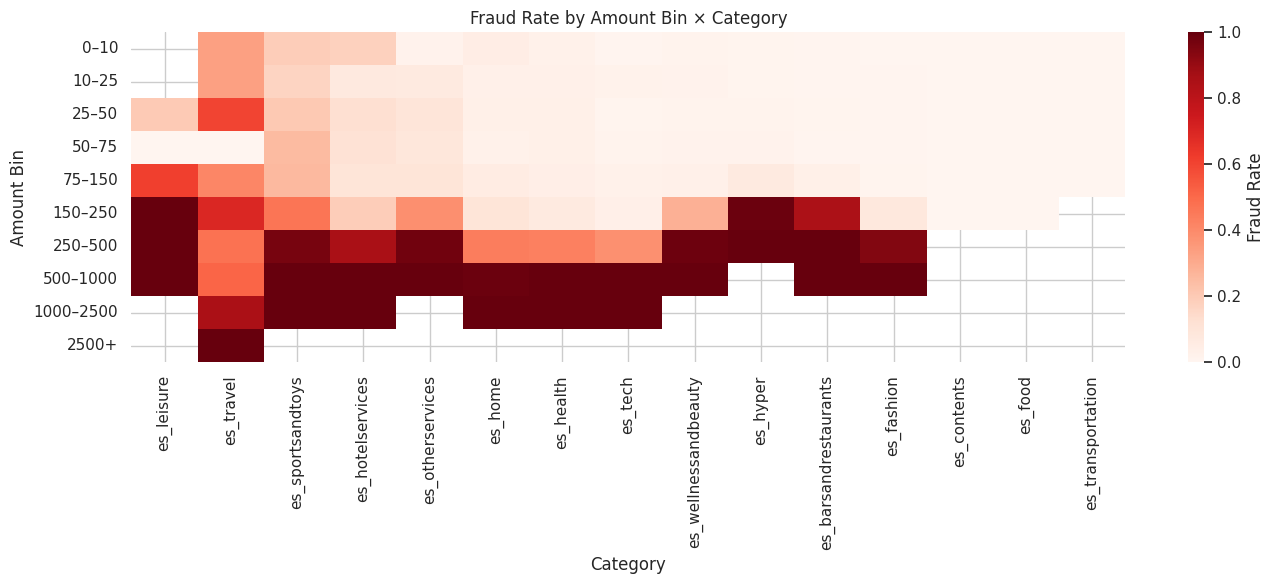

In [18]:
def _norm_bin_label(s: str) -> str:
    # unify dashes to '-', remove spaces/commas
    return (str(s).replace('\u2013','-').replace('\u2014','-')
                  .replace('–','-').replace('—','-')
                  .replace(' ', '').replace(',', ''))

def _left_edge(s: str) -> float:
    t = _norm_bin_label(s).replace('+','')
    try:
        return float(t.split('-', 1)[0])
    except Exception:
        return np.inf

u = pd.Series(dfc['amount_bin'].dropna().astype(str).unique())
order_df = pd.DataFrame({'label_orig': u})
order_df['left'] = order_df['label_orig'].map(_left_edge)
order_df = order_df.sort_values('left', kind='mergesort')
amount_order = order_df['label_orig'].tolist()

#order categories by overall fraud rate (descending) for readability
cat_order = (dfc.groupby('category_clean')['fraud']
               .mean()
               .sort_values(ascending=False)
               .index.tolist())

#Pivot of fraud rate (mean) ---
pivot = pd.crosstab(dfc['amount_bin'], dfc['category_clean'],
                    values=dfc['fraud'], aggfunc='mean')

# Reindex rows/columns to the chosen orders
pivot = pivot.reindex(index=amount_order, columns=cat_order)


plt.figure(figsize=(14, 6))
ax = sns.heatmap(pivot, cmap='Reds', vmin=0, vmax=1,
                 cbar_kws={'label': 'Fraud Rate'})
ax.set_title('Fraud Rate by Amount Bin × Category')
ax.set_xlabel('Category')
ax.set_ylabel('Amount Bin')

# Make the colorbar show percentages
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1.0))
cbar.update_ticks()

plt.tight_layout()
plt.show()
